In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# from character import Character, character_category
import pandas

In [4]:
from yomi.historical_record import games as yomi_games
from bacon import games as bacon_games
    
data_name, hist_games = yomi_games()
fit_dir = f"fits/{data_name}"

0: 2019-02-06T14:10:23.446708.parquet
1: 2019-03-01T16:02:11.357293.parquet
2: 2019-03-20T11:08:29.818291.parquet
3: 2019-03-20T11:34:49.116008.parquet
4: 2019-03-20T11:53:04.122784.parquet
5: 2019-03-20T12:12:41.287228.parquet
6: 2019-03-20T13:05:25.631284.parquet
7: 2019-03-20T13:07:30.217948.parquet
8: 2019-03-20T13:25:21.835913.parquet
9: 2019-03-20T13:42:10.277826.parquet
10: 2019-03-25T00:13:35.971313.parquet
11: 2019-04-03T02:07:21.751254.parquet
12: 2019-04-03T02:09:32.849059.parquet
13: 2019-04-03T02:11:29.374233.parquet
14: 2019-04-04T15:30:53.645834.parquet
15: 2019-04-09T23:23:47.747366.parquet
16: 2019-04-09T23:30:23.260438.parquet
17: 2019-04-25T15:32:57.848454.parquet
18: 2019-04-25T15:43:12.556940.parquet
19: 2019-04-25T16:08:41.265091.parquet


Load game data: 19


,tournament_name,match_date,player_1,character_1,win,character_2,player_2,elo_before_1,elo_after_1,elo_before_2,elo_after_2,version_1,version_2
index,,,,,,,,,,,,,
9414,Summer Smash,2014-07-06,mallorean_thug,DeGrey,1,Valerie,Nathan,NaN,NaN,1475.750000,1476.000000,2,2
9415,Summer Smash,2014-07-06,mallorean_thug,DeGrey,1,Valerie,Nathan,NaN,NaN,1475.750000,1476.000000,2,2
9416,Summer Smash,2014-07-06,mallorean_thug,DeGrey,1,Valerie,Nathan,NaN,NaN,1475.750000,1476.000000,2,2
9417,Summer Smash,2014-07-06,mallorean_thug,DeGrey,1,Valerie,Nathan,NaN,NaN,1475.750000,1476.000000,2,2
9494,Summer Smash,2014-07-06,Morn,DeGrey,0,Menelker,Tipzntrix,1476.000000,1427.500000,NaN,NaN,2,2
9495,Summer Smash,2014-07-06,Morn,DeGrey,0,Menelker,Tipzntrix,1476.000000,1427.500000,NaN,NaN,2,2
9496,Summer Smash,2014-07-06,Tipzntrix,Menelker,1,Setsuki,Morn,NaN,NaN,1476.000000,1427.500000,2,2
9497,Summer Smash,2014-07-06,Morn,Lum,0,Menelker,Tipzntrix,1476.000000,1427.500000,NaN,NaN,2,2
9506,Summer Smash,2014-07-06,mallorean_thug,DeGrey,1,Menelker,Tipzntrix,NaN,NaN,NaN,NaN,2,2


In [4]:
hist_games

,tournament_name,match_date,player_1,character_1,win,character_2,player_2,elo_before_1,elo_after_1,elo_before_2,elo_after_2,version_1,version_2
index,,,,,,,,,,,,,
9410,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833333,1563.039174,1500.000000,1452.000000,2,2
9411,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833333,1563.039174,1500.000000,1452.000000,2,2
9412,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833333,1563.039174,1500.000000,1452.000000,2,2
9413,Summer Smash,2014-07-06,ntillerman,Argagarg,1,Menelker,Felix,1547.833333,1563.039174,1500.000000,1452.000000,2,2
9418,Summer Smash,2014-07-06,Djister,Rook,0,Zane,Bob199,1500.125000,1500.625000,1604.313812,1620.398168,2,2
9419,Summer Smash,2014-07-06,Djister,Rook,0,Zane,Bob199,1500.125000,1500.625000,1604.313812,1620.398168,2,2
9420,Summer Smash,2014-07-06,Djister,Rook,0,Zane,Bob199,1500.125000,1500.625000,1604.313812,1620.398168,2,2
9421,Summer Smash,2014-07-06,Djister,Rook,0,Zane,Bob199,1500.125000,1500.625000,1604.313812,1620.398168,2,2
9422,Summer Smash,2014-07-06,Xom,Onimaru,1,Setsuki,rybalko,1516.333333,1500.166667,1500.000000,1452.000000,2,2


In [5]:
hist_games.groupby(['character_1']).size()

character_1
Argagarg      2622
BBB           1440
DeGrey        2051
Geiger        1792
Gloria        1478
Grave         1923
Gwen          1305
Jaina          831
Lum            871
Menelker       854
Midori         804
Onimaru       1063
Persephone     649
Quince         855
Rook           654
Setsuki       1082
Troq           652
Valerie        261
Vendetta       111
Zane            97
dtype: int64

In [7]:
from model import YomiModel

models = {model.model_name: model for model in [
#     YomiModel(
#         "skill_mult_player_tournament_part_pooled_char_skill.stan",
#         [
#             'skill', 'mu', 'muv', 'player_skill', 'baseline_skill',
#             'tournament_variance', 'player_variance', 'log_lik', 'win_hat',
#             'char_skill',
#         ]
#     ),
#     YomiModel(
#         "skill_mult_player_tournament_part_pooled.stan",
#         [
#             'skill', 'mu', 'muv', 'player_skill', 'baseline_skill',
#             'tournament_variance', 'player_variance', 'log_lik', 'win_hat',
#         ]
#     ),
#     YomiModel(
#         "skill_mult_player_tournament.stan",
#         [
#             'skill', 'mu', 'muv', 'log_lik', 'win_hat',
#         ]
#     ),
#     YomiModel(
#         "player_tournament.stan",
#         [
#             'skill', 'mu', 'log_lik', 'win_hat',
#         ]
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "player_tournament_iterative_pooling.stan",
#         [
#             'skill', 'skill_adjust', 'skill_adjust_variance', 'pooled_skill_adjust', 'mu', 'log_lik', 'win_hat',
#         ]
#     ),
#     YomiModel(
#         "char_skill_only.stan",
#         [
#             'char_skill', 'mu', 'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         "player_tournament_part_pool.stan",
#         [
#             'skill', 'mu', 'player_skill', 'raw_player_skill', 'raw_skill', 'baseline_skill', 'tournament_variance', 'player_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "player_tournament_min_pool.stan",
#         [
#             'skill', 'mu', 'player_skill', 'global_player_skill', 'player_variance', 'tournament_variance', 'skill_in_tournament',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         "player_tournament_part_pool_char_skill.stan",
#         [
#             'skill', 'char_skill', 'mu', 'player_skill', 'baseline_skill', 'tournament_variance', 'player_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         "player_tournament_char_skill.stan",
#         [
#             'skill', 'char_skill', 'mu', 'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "elo_only.stan",
#         [
#             'mu', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_pooled_elo.stan",
#         [
#             'mu', 'char_skill', 'char_skill_variance', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
    YomiModel(
        hist_games,
        fit_dir,
        "char_skill_elo_skill_deficit.stan",
        [
            'mu', 'char_skill', 'elo_logit_scale',
            'log_lik', 'win_hat',
        ],
        min_games=0
    ),
    YomiModel(
        hist_games,
        fit_dir,
        "char_skill_elo_skill_deficit_versioned.stan",
        [
            'mu', 'vmu', 'char_skill', 'elo_logit_scale',
            'log_lik', 'win_hat',
        ],
        min_games=0
    ),
    YomiModel(
        hist_games,
        fit_dir,
        "char_skill_elo_skill_deficit_versioned_hier.stan",
        [
            'mu_mean', 'mu_std', 'vmu', 'char_skill', 'elo_logit_scale',
            'log_lik', 'win_hat',
        ],
        min_games=0
    ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_pooled.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'char_skill_mean', 'char_skill_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_pooled_weighted.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'char_skill_mean', 'char_skill_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_weighted.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_priors.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_pooled_priors.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'char_skill_mean', 'char_skill_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_pooled_weighted_priors.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'char_skill_mean', 'char_skill_variance',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
#     YomiModel(
#         hist_games,
#         fit_dir,
#         "char_skill_elo_skill_deficit_weighted_priors.stan",
#         [
#             'mu', 'char_skill', 'elo_logit_scale',
#             'log_lik', 'win_hat',
#         ]                      
#     ),
]}

In [14]:
# Make sure we have data for all the models without keeping them all in memory until we need them

for name, model in models.items():
    print(f"Loading {name}...", end='')
    model.sample_infdata(warmup=1500, min_samples=2000)
    print(f" loaded.")

Loading char_skill_elo_skill_deficit... loaded.
Loading char_skill_elo_skill_deficit_versioned...

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50a151835b8ba18c03cd6a7ef2800ff0 NOW.


 loaded.
Loading char_skill_elo_skill_deficit_versioned_hier...Converting to InferenceData


INFO:root:Unable to unpickle fit, resampling
Traceback (most recent call last):
  File "/code/model.py", line 441, in inf_data
    inf_data = arviz.data.InferenceData.from_netcdf(self.netcdf_filename)
  File "/usr/local/lib/python3.7/site-packages/arviz/data/inference_data.py", line 58, in from_netcdf
    with nc.Dataset(filename, mode="r") as data:
  File "netCDF4/_netCDF4.pyx", line 2285, in netCDF4._netCDF4.Dataset.__init__
  File "netCDF4/_netCDF4.pyx", line 1855, in netCDF4._netCDF4._ensure_nc_success
FileNotFoundError: [Errno 2] No such file or directory: b'fits/bacon/2019-03-27T17:16:59.113586/char_skill_elo_skill_deficit_versioned_hier-50a151/warmup-1500/min-games-30/0.netcdf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/code/model.py", line 392, in fit
    with open(self.fit_filename, "rb") as fit_file:
FileNotFoundError: [Errno 2] No such file or directory: 'fits/bacon/2019-03-27T17:16:59.113586/char_skill_e

Converting to InferenceData


INFO:root:Unable to unpickle fit, resampling
Traceback (most recent call last):
  File "/code/model.py", line 441, in inf_data
    inf_data = arviz.data.InferenceData.from_netcdf(self.netcdf_filename)
  File "/usr/local/lib/python3.7/site-packages/arviz/data/inference_data.py", line 58, in from_netcdf
    with nc.Dataset(filename, mode="r") as data:
  File "netCDF4/_netCDF4.pyx", line 2285, in netCDF4._netCDF4.Dataset.__init__
  File "netCDF4/_netCDF4.pyx", line 1855, in netCDF4._netCDF4._ensure_nc_success
FileNotFoundError: [Errno 2] No such file or directory: b'fits/bacon/2019-03-27T17:16:59.113586/char_skill_elo_skill_deficit_versioned_hier-50a151/warmup-1500/min-games-30/2.netcdf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/code/model.py", line 392, in fit
    with open(self.fit_filename, "rb") as fit_file:
FileNotFoundError: [Errno 2] No such file or directory: 'fits/bacon/2019-03-27T17:16:59.113586/char_skill_e

Converting to InferenceData


INFO:root:Unable to unpickle fit, resampling
Traceback (most recent call last):
  File "/code/model.py", line 441, in inf_data
    inf_data = arviz.data.InferenceData.from_netcdf(self.netcdf_filename)
  File "/usr/local/lib/python3.7/site-packages/arviz/data/inference_data.py", line 58, in from_netcdf
    with nc.Dataset(filename, mode="r") as data:
  File "netCDF4/_netCDF4.pyx", line 2285, in netCDF4._netCDF4.Dataset.__init__
  File "netCDF4/_netCDF4.pyx", line 1855, in netCDF4._netCDF4._ensure_nc_success
FileNotFoundError: [Errno 2] No such file or directory: b'fits/bacon/2019-03-27T17:16:59.113586/char_skill_elo_skill_deficit_versioned_hier-50a151/warmup-1500/min-games-30/3.netcdf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/code/model.py", line 392, in fit
    with open(self.fit_filename, "rb") as fit_file:
FileNotFoundError: [Errno 2] No such file or directory: 'fits/bacon/2019-03-27T17:16:59.113586/char_skill_e

Converting to InferenceData
 loaded.


In [15]:
import arviz
comparison = arviz.compare(
    dataset_dict={
        name: model.sample_infdata(warmup=1500, min_samples=2000)
        for name, model
        in models.items()
    },
    ic='loo',
)

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
char_skill_elo_skill_deficit,8975.28,379.722,0,0.537402,86.6823,0,0,deviance
char_skill_elo_skill_deficit_versioned,8976.96,356.294,1.68316,0.462598,84.8991,9.81512,0,deviance
char_skill_elo_skill_deficit_versioned_hier,8986.26,402.946,10.9769,6.66134e-16,86.025,9.20211,0,deviance


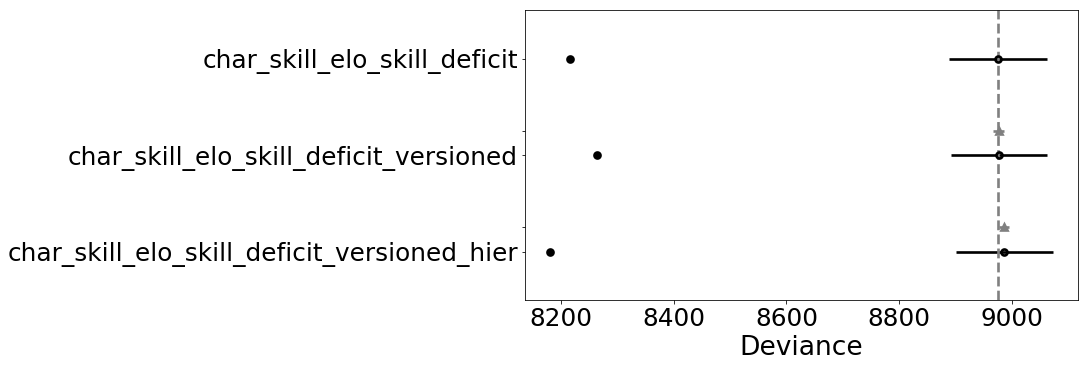

In [16]:
display(comparison)
arviz.plot_compare(comparison, figsize=(15, 5))

In [40]:
df = models['char_skill_elo_skill_deficit_versioned'].summary_dataframe(1500, 2000)

INFO:root:Loading parquet fits/bacon/2019-03-26T15:13:11.423193/char_skill_elo_skill_deficit_versioned-46fc1d/warmup-1500/min-games-30/summary-2000-samples.parquet
INFO:root:Dataframe loading failed
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/fastparquet/api.py", line 110, in __init__
    with open_with(fn2, 'rb') as f:
  File "/usr/local/lib/python3.7/site-packages/fastparquet/util.py", line 38, in default_open
    return open(f, mode)
FileNotFoundError: [Errno 2] No such file or directory: 'fits/bacon/2019-03-26T15:13:11.423193/char_skill_elo_skill_deficit_versioned-46fc1d/warmup-1500/min-games-30/summary-2000-samples.parquet/_metadata'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/code/model.py", line 293, in summary_dataframe
    summary_results = pandas.read_parquet(parquet_filename)
  File "/usr/local/lib/python3.7/site-packages/pandas/io/parquet.py", line 282, in read_parque

In [41]:
df2 = (df
       .rename(columns={f'mu[{ix}]': f'mu[{chars}]' for chars, ix in models['char_skill_elo_skill_deficit_versioned'].mu_index.items()})
       .rename(columns={f'vmu[{ix}]': f'mu[{chars}]' for chars, ix in models['char_skill_elo_skill_deficit_versioned'].version_mu_index.items()})
      )

In [42]:
df2[[col for col in df2.columns if 'Seven' in col and (col.startswith('mu') or col.startswith('vmu'))]].transpose()

,mean,std
"mu[('Alexian', 'Seven')]",-0.240385,0.391813
"mu[('Anath', 'Seven')]",-0.206761,0.379847
"mu[('Burman', 'Seven')]",0.343838,0.423341
"mu[('Cadenza', 'Seven')]",0.376645,0.375458
"mu[('Cesar', 'Seven')]",0.102697,0.380513
"mu[('Eligor', 'Seven')]",-0.057689,0.352844
"mu[('Evil Hikaru', 'Seven')]",0.050169,0.398211
"mu[('Hikaru', 'Seven')]",-0.288710,0.376077
"mu[('Iri', 'Seven')]",0.119622,0.416834
"mu[('Kallistar', 'Seven')]",0.275284,0.390955


In [8]:
from render import *

render = YomiRender(
    data_name,
    models['char_skill_elo_skill_deficit'],
    1500,
    2000,
)


In [14]:
print(render.balanced_matchups())

abs_unbalance  win_rate
c1       c2                                 
Argagarg Geiger           0.071754  4.928246
         Persephone       0.076407  4.923593
         Troq             0.175578  4.824422
         Menelker         0.289139  5.289139
         Setsuki          0.302915  5.302915
BBB      Menelker         0.060560  4.939440
         Valerie          0.061945  5.061945
         Setsuki          0.124731  4.875269
         Lum              0.246139  4.753861
         Vendetta         0.344468  5.344468
DeGrey   Persephone       0.005876  4.994124
         Geiger           0.035660  4.964340
         Grave            0.213005  4.786995
         Quince           0.300505  5.300505
         Argagarg         0.337450  5.337450
Geiger   DeGrey           0.035660  5.035660
         Argagarg         0.071754  5.071754
         Lum              0.101807  5.101807
         Setsuki          0.251876  5.251876
         Gwen             0.256607  4.743393
Gloria   Lum              0.017763  5.017763
         Onimaru          0.109319  4.890681
         Menelker         0.179212  5.179212
         Valerie          0.216402  4.783598
         Persephone       0.263131  4.736869
Grave    Onimaru          0.054705  5.054705
         Menelker         0.059566  5.059566
         Troq             0.113904  4.886096
         DeGrey           0.213005  5.213005
         Jaina            0.225384  5.225384
...                            ...       ...
Rook     Setsuki          0.011443  4.988557
         Troq             0.073229  5.073229
         Vendetta         0.171278  4.828722
         Grave            0.266159  4.733841
         Onimaru          0.320665  4.679335
Setsuki  Rook             0.011443  5.011443
         Quince           0.023337  5.023337
         BBB              0.124731  5.124731
         Midori           0.192417  4.807583
         Geiger           0.251876  4.748124
Troq     Midori           0.062359  5.062359
         Rook             0.073229  4.926771
         Grave            0.113904  5.113904
         Vendetta         0.144263  4.855737
         Argagarg         0.175578  5.175578
Valerie  Quince           0.005629  4.994371
         BBB              0.061945  4.938055
         Zane             0.163406  4.836594
         Menelker         0.192586  4.807414
         Gloria           0.216402  5.216402
Vendetta Gwen             0.124664  4.875336
         Troq             0.144263  5.144263
         Rook             0.171278  5.171278
         Zane             0.184388  4.815612
         Persephone       0.194201  5.194201
Zane     Valerie          0.163406  5.163406
         Vendetta         0.184388  5.184388
         Lum              0.218659  4.781341
         Onimaru          0.235170  4.764830
         DeGrey           0.338706  5.338706

[100 rows x 2 columns]

| Character | Counterpick |
|---|---|
|:Argagarg:|:Geiger: :Persephone: :Troq: :Menelker: :Setsuki:|
|:BBB:|:Menelker: :Valerie: :Setsuki: :Lum: :Vendetta:|
|:DeGrey:|:Persephone: :Geiger: :Grave: :Quince: :Argagarg:|
|:Geiger:|:DeGrey: :Argagarg: :Lum: :Setsuki: :Gwen:|
|:Gloria:|:Lum: :Onimaru: :Menelker: :Valerie: :Persephone:|
|:Grave:|:Onimaru: :Menelker: :Troq: :DeGrey: :Jaina:|
|:Gwen:|:Vendetta: :Geiger: :Gloria: :Jaina: :Menelker:|
|:Jaina:|:Quince: :Grave: :Gwen: :BBB: :Midori:|
|:Lum:|:Gloria: :Midori: :Geiger: :Troq: :Zane:|
|:Menelker:|:Grave: :Persephone: :BBB: :Midori: :Gloria:|
|:Midori:|:Troq: :Lum: :Menelker: :Onimaru: :Setsuki:|
|:Onimaru:|:Grave: :Gloria: :Midori: :Quince: :Zane:|
|:Persephone:|:DeGrey: :Menelker: :Quince: :Argagarg: :Vendetta:|
|:Quince:|:Valerie: :Setsuki: :Persephone: :Jaina: :Onimaru:|
|:Rook:|:Setsuki: :Troq: :Vendetta: :Grave: :Onimaru:|
|:Setsuki:|:Rook: :Quince: :BBB: :Midori: :Geiger:|
|:Troq:|:Midori: :Rook: :Grave: :Vendetta: :Argagarg:|


In [27]:
mu_stats = pandas.concat([
    render.matchups[render.matchups.c1 <= render.matchups.c2].groupby(['c1', 'c2']).win_rate.median(),
    hist_games.groupby(['character_1', 'character_2']).size().rename('matches_played').astype(int),
], axis=1).reset_index()

In [65]:
even_mus = mu_stats[(4.5 <= mu_stats.win_rate) & (mu_stats.win_rate <= 5.5) & (mu_stats.c1 != mu_stats.c2)].sort_values(['matches_played'])

least_played_even = pandas.concat([
    even_mus[(even_mus.c1 == char) | (even_mus.c2 == char)].head(1)
    for char in Character
]).drop_duplicates()

unbalanced_mus = mu_stats[((6 <= mu_stats.win_rate) | (mu_stats.win_rate <= 4)) & (mu_stats.c1 != mu_stats.c2)].sort_values(['matches_played'])

least_played_unbalanced = pandas.concat([
    unbalanced_mus[(unbalanced_mus.c1 == char) | (unbalanced_mus.c2 == char)].head(1)
    for char in Character
]).drop_duplicates()

In [66]:
table = least_played_even[['c1', 'c2']].append(least_played_even[['c1', 'c2']].rename(columns={'c1': 'c2', 'c2': 'c1'})).drop_duplicates().sort_values(['c1', 'c2'])

print('| - | - |')
for character in Character:
    opponents = ' '.join(f':{row.c2}:' for row in table[table.c1 == character].itertuples())
    print(f'|:{character}:|{opponents}|')

| - | - |
|:Argagarg:|:Menelker:|
|:BBB:|:Jaina: :Lum: :Menelker: :Setsuki: :Vendetta:|
|:DeGrey:|:Gloria:|
|:Geiger:|:Gwen:|
|:Gloria:|:DeGrey: :Onimaru: :Valerie:|
|:Grave:|:Jaina:|
|:Gwen:|:Geiger:|
|:Jaina:|:BBB: :Grave: :Persephone: :Quince:|
|:Lum:|:BBB:|
|:Menelker:|:Argagarg: :BBB: :Rook:|
|:Midori:|:Troq: :Valerie: :Zane:|
|:Onimaru:|:Gloria:|
|:Persephone:|:Jaina:|
|:Quince:|:Jaina:|
|:Rook:|:Menelker:|
|:Setsuki:|:BBB:|
|:Troq:|:Midori:|
|:Valerie:|:Gloria: :Midori:|
|:Vendetta:|:BBB:|
|:Zane:|:Midori:|


In [67]:
table = least_played_unbalanced[['c1', 'c2']].append(least_played_unbalanced[['c1', 'c2']].rename(columns={'c1': 'c2', 'c2': 'c1'})).drop_duplicates().sort_values(['c1', 'c2'])

print('| - | - |')
for character in Character:
    opponents = ' '.join(f':{row.c2}:' for row in table[table.c1 == character].itertuples())
    print(f'|:{character}:|{opponents}|')

| - | - |
|:Argagarg:|:Jaina:|
|:BBB:|:Geiger: :Zane:|
|:DeGrey:|:Valerie:|
|:Geiger:|:BBB: :Jaina:|
|:Gloria:|:Midori: :Vendetta:|
|:Grave:||
|:Gwen:|:Lum: :Onimaru:|
|:Jaina:|:Argagarg: :Geiger: :Lum: :Rook: :Valerie:|
|:Lum:|:Gwen: :Jaina:|
|:Menelker:||
|:Midori:|:Gloria:|
|:Onimaru:|:Gwen:|
|:Persephone:|:Setsuki:|
|:Quince:|:Troq:|
|:Rook:|:Jaina:|
|:Setsuki:|:Persephone:|
|:Troq:|:Quince:|
|:Valerie:|:DeGrey: :Jaina:|
|:Vendetta:|:Gloria:|
|:Zane:|:BBB:|


In [34]:
from render import *
from datetime import datetime

players = hist_games[hist_games.elo_before_1 > 1700].player_1.append(
    hist_games[hist_games.elo_before_2 > 1700].player_2
).append(
    hist_games[hist_games.match_date > datetime(2018, 1, 1)].player_1
).append(
    hist_games[hist_games.match_date > datetime(2018, 1, 1)].player_1
).unique()

for model in models.values():
    if 'deficit' not in model.model_name:
        continue
    render = YomiRender(data_name, model, 1500, 2000)
    print(render.model.model_name)
    for player in players:
        print(player)
        render.render_char_skill(player)
    render.render_matchup_chart()

INFO:root:Loading parquet fits/2019-02-06T14:10:23.446708/char_skill_elo_skill_deficit-7cdf01/warmup-1500/0.parquet


char_skill_elo_skill_deficit
MadKing


KeyboardInterrupt: 

In [62]:
render = YomiRender(data_name, models['char_skill_elo_skill_deficit_weighted'], 1500, 2000)

In [77]:

print(render.model.model_name)
for player in players:
    print(player)
    render.render_char_win_chance(player)
render.render_matchup_chart()

char_skill_elo_skill_deficit_weighted
MadKing


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Raziek


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Mallorean_Thug


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Juushichi


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Redless


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


tipzntrix


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


deluks917


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Mercyful Fate


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


the-cap


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


enomus


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Bob199


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)


ClanNatioy


/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)
/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Jengajam


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Leontes


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


FenixOfTheAshes


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


EricF


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


hartley


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Fivec


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Bomber678


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Staryu


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


lowtierhero


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Niijima-San


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Ryker


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Thelo


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


ntillerman


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


wampuh


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


zytearK


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


cpat


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


drnd


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


mastrblastr


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Southpaw Hare


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Dietz


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


ratxt1


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Corroyeur


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Caralad


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


CKR


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


CloudCuckooCountry


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Legion


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


ExSeth


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


mysticjuicer


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


BD_Corro


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Fluffiness


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


SirHandsome


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Fusxfaranto


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


flagrantangles


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


sharpobject


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


MR


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Zqxx


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Djister


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


GutterOwl


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Hobusu


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Three Headed Monkey


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


ArthurWynne


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Ivan


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


snoc


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


vengefulpickle


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Desiderata


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Hamvvar


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


MysticDeadman


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


thehug0naut


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Castanietzsche


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


FaceOnMars


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Attilian


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


UTRALAW


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


HolyTyrant27


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


copper8642


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Tumbles


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


lum_at_1st_sight


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


variable


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


JonnyD


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Zejety


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


TokH


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


mi-go hunter


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


jamie-chan


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


CarpeGuitarrem


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Rinzler


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Shax


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Xiba


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


LizardLinc


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Journeyboy


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Oddus


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


NobodysHero


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


Luke1705


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)


JodySalerno


/code/render.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_median'] = char_skill.character.apply(lambda c: skill_summaries['median'][c]).astype(float)
/code/render.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  char_skill['skill_std'] = char_skill.character.apply(lambda c: skill_summaries['std'][c]).astype(float)
/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/lo

In [75]:
print(render.balanced_matchups())

abs_unbalance  win_rate
c1       c2                                 
Argagarg Argagarg         0.015828  4.984172
         Persephone       0.049204  4.950796
         Geiger           0.086233  4.913767
         Valerie          0.198909  5.198909
         DeGrey           0.211340  4.788660
         Menelker         0.249568  5.249568
BBB      Jaina            0.008969  4.991031
         Valerie          0.019851  4.980149
         BBB              0.023652  4.976348
         Menelker         0.144448  5.144448
         Gwen             0.452265  4.547735
         Lum              0.469804  4.530196
DeGrey   Geiger           0.032125  4.967875
         DeGrey           0.041351  4.958649
         Quince           0.059639  5.059639
         Rook             0.118631  5.118631
         Gwen             0.161420  5.161420
         Argagarg         0.211340  5.211340
Geiger   DeGrey           0.032125  5.032125
         Geiger           0.037884  5.037884
         Argagarg         0.086233  5.086233
         Gwen             0.089284  5.089284
         Menelker         0.134689  4.865311
         Rook             0.176484  5.176484
Gloria   Gloria           0.004388  5.004388
         Lum              0.024390  5.024390
         Valerie          0.173775  4.826225
         Menelker         0.257666  5.257666
         Rook             0.286090  5.286090
         Setsuki          0.301694  5.301694
...                            ...       ...
Setsuki  Setsuki          0.015629  5.015629
         Midori           0.018370  4.981630
         Quince           0.059290  5.059290
         Rook             0.102065  5.102065
         Grave            0.187718  4.812282
         Gloria           0.301694  4.698306
Troq     Vendetta         0.002662  4.997338
         Midori           0.007475  4.992525
         Grave            0.024144  4.975856
         Troq             0.025129  4.974871
         Rook             0.048424  4.951576
         Persephone       0.102871  4.897129
Valerie  Valerie          0.017628  5.017628
         BBB              0.019851  5.019851
         Grave            0.038131  4.961869
         Quince           0.074726  4.925274
         Rook             0.164398  4.835602
         Zane             0.172488  4.827512
Vendetta Troq             0.002662  5.002662
         Rook             0.010737  5.010737
         Vendetta         0.019517  4.980483
         Midori           0.112034  5.112034
         Gwen             0.116179  4.883821
         Persephone       0.225770  4.774230
Zane     Zane             0.016703  4.983297
         Valerie          0.172488  5.172488
         Vendetta         0.255672  5.255672
         Lum              0.301863  4.698137
         Grave            0.306939  5.306939
         DeGrey           0.328825  5.328825

[120 rows x 2 columns]

| Character | Counterpick |
|---|---|
|:Argagarg:|:Argagarg: :Persephone: :Geiger: :Valerie: :DeGrey: :Menelker:|
|:BBB:|:Jaina: :Valerie: :BBB: :Menelker: :Gwen: :Lum:|
|:DeGrey:|:Geiger: :DeGrey: :Quince: :Rook: :Gwen: :Argagarg:|
|:Geiger:|:DeGrey: :Geiger: :Argagarg: :Gwen: :Menelker: :Rook:|
|:Gloria:|:Gloria: :Lum: :Valerie: :Menelker: :Rook: :Setsuki:|
|:Grave:|:Grave: :Troq: :Valerie: :Jaina: :Onimaru: :Menelker:|
|:Gwen:|:Gwen: :Geiger: :Vendetta: :DeGrey: :Jaina: :Rook:|
|:Jaina:|:BBB: :Jaina: :Grave: :Gwen: :Quince: :Persephone:|
|:Lum:|:Lum: :Gloria: :Midori: :Geiger: :Troq: :Zane:|
|:Menelker:|:Menelker: :Midori: :Persephone: :Geiger: :BBB: :Grave:|
|:Midori:|:Troq: :Onimaru: :Setsuki: :Midori: :Menelker: :Vendetta:|
|:Onimaru:|:Midori: :Onimaru: :Grave: :Gloria: :Zane: :Vendetta:|
|:Persephone:|:Quince: :Rook: :Persephone: :Argagarg: :Troq: :Menelker:|
|:Quince:|:Quince: :Persephone: :Setsuki: :DeGrey: :Valerie: :Jaina:|
|:Rook:|:Persephone: :Rook: :Vendetta: :Troq: :Sets

In [ ]:
import pystan

for chain, sample in enumerate(models['char_skill_elo']._samples(warmup=1500, min_samples=2000)):
    print(chain, pystan.diagnostics.check_rhat(sample.fit))

In [23]:
pystan.diagnostics.check_n_eff(fit, verbose=2)

INFO:pystan:n_eff / iter looks reasonable for all parameters


True

In [ ]:
arviz.plot_ppc(inf_data, alpha=0.3, kind='cumulative', figsize=(12, 6), textsize=14)

In [ ]:
std_devs = fit_results[[
    col for col in fit_results.columns
    if col.startswith('muv[') or col.startswith('mmv[')
]].rename(
    columns={'muv[{}]'.format(ix): "{.value}-{.value}".format(c1, c2) for ((c1, c2), ix) in mu_index.items()}
).rename(
    columns={'mmv[{}]'.format(ix): "{.value}-{.value}".format(c1, c1) for (c1, ix) in mirror_index.items()}
).unstack().rename('std_dev').reset_index()
std_devs['c1'] = std_devs.level_0.apply(lambda x: Character(x.split('-')[0])).astype(character_category)
std_devs['c2'] = std_devs.level_0.apply(lambda x: Character(x.split('-')[1])).astype(character_category)
del(std_devs['level_0'])
std_devs = std_devs.rename(columns={'level_1': 'sample'})

In [ ]:
std_devs.info(memory_usage='deep')

In [ ]:
flipped = std_devs[std_devs.c1 != std_devs.c2].rename(columns={'c1': 'c2', 'c2': 'c1'})

std_devs = std_devs.append(flipped)

In [ ]:
std_devs.info(memory_usage='deep')

In [ ]:
import math
#std_devs['std_dev'] = 10*(std_devs['std_dev'].rpow(math.e)) / (1 + std_devs['std_dev'].rpow(math.e))-5

median_rates = pandas.DataFrame(std_devs.groupby(['c1', 'c2']).std_dev.median().rename('median_std_dev'))
text_color = median_rates.reset_index().median_std_dev.apply(lambda x: 'white' if x < 1 else 'black')

std_devs = std_devs.join(median_rates, on=['c1', 'c2'])

In [ ]:
std_devs.info(memory_usage='deep')

In [ ]:
from plotnine import *
from IPython.core.display import display

std_dev_chart = (
    ggplot(std_devs, aes(x='0', y='std_dev', fill='median_std_dev'))
    + geom_violin()
    + geom_text(
        data=median_rates.reset_index(),
        mapping=aes(label='median_std_dev', x=.4, y=2, size=9),
        #color=text_color,
        format_string='median={:.2}',
    )
    + facet_grid('c1 ~ c2')
    + coord_flip()
    + theme(figure_size=(25, 15))
    + scale_fill_gradient2(midpoint=1)
)

filename = f'yomi-std-dev-estimates-{model_hash}-{data_hash}.png'
std_dev_chart.save(filename)

In [ ]:
(
    ggplot(std_devs.sample(frac=0.01), aes(x='0', y='std_dev', fill='median_std_dev'))
    + geom_violin()
    + facet_wrap('c1')
    + coord_flip()
    + theme(figure_size=(5, 5))
    + scale_fill_gradient2(midpoint=1)
).save(f'skill-effects-character-{model_hash}-{data_hash}.png')

In [66]:
render_player, render_players = player_skill(models['skill_mult_with_char_skill'], 1500, 2000)

/code/model.py:236: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  for par in self.model.pars:


In [ ]:
num_samples = player_tournament_skill['sample'].nunique()
skill_subsample = pandas.cut(
    player_tournament_skill.set_index(['tournament', 'player']).skill,
    bins=[x-0.5 for x in range(-9, 9)],
    precision=0,
).rename('skill').reset_index().groupby(
    ['tournament', 'player', 'skill']
).size().rename('skill_fraction').reset_index(['skill'])

skill_subsample['skill_fraction'] /= num_samples

game_skill = games.join(
    skill_subsample.rename(columns={'skill': 'skill_1', 'skill_fraction': 'skill_fraction_1'}),
    on=('tournament_name', 'player_1')
).join(
    skill_subsample.rename(columns={'skill': 'skill_2', 'skill_fraction': 'skill_fraction_2'}),
    on=('tournament_name', 'player_2')
)

flipped = game_skill[game_skill.character_1 < game_skill.character_2]
flipped = flipped.rename(columns={
    'character_1': 'character_2',
    'character_2': 'character_1',
    'skill_1': 'skill_2',
    'skill_2': 'skill_1',
    'skill_fraction_1': 'skill_fraction_2',
    'skill_fraction_2': 'skill_fraction_1',
})
flipped['win'] = 1-flipped.win
game_skill = game_skill.append(flipped)

game_skill['skill_fraction'] = game_skill.skill_fraction_1 * game_skill.skill_fraction_2
game_skill['win_fraction'] = game_skill.win * game_skill.skill_fraction



In [ ]:
game_skill.info(memory_usage='deep')

In [ ]:
game_skill.groupby(['character_1', 'character_2', 'skill_1', 'skill_2']).sum().dropna().sort_values(by='win_fraction', ascending=False).head()

In [ ]:
import itertools
from plotnine import *

df = game_skill.groupby(
    ['character_1', 'character_2', 'skill_1', 'skill_2']
).sum().rename(columns={'skill_fraction': 'games_played', 'win_fraction': 'p1_wins'}).reset_index().dropna()
df['p1_win_prob'] = df.p1_wins / df.games_played
max_count = df['games_played'].max()
df['played_color'] = df.games_played.apply(lambda p: p > max_count*.8)
df['prob_color'] = df.p1_win_prob.apply(lambda p: not (.2 < p < .8))

df = df[df.games_played >= 0.05]

character_subsets = [list(Character)[x:x+4] for x in range(0, len(Character), 4)]

show_legends = False

for ((y, c1_subset), (x, c2_subset)) in itertools.product(enumerate(character_subsets), enumerate(character_subsets)):
    subset_selector = df.character_1.isin(c1_subset) & df.character_2.isin(c2_subset)
    
    tile_plot = (
        ggplot(
            df[subset_selector],
            aes(y='factor(skill_1)', x='factor(skill_2)')
        )
        + facet_grid('character_1 ~ character_2', labeller='label_both')
        + scale_color_grey(start=0, end=1, limits=[False, True])
        + labs(y='p1 skill', x='p2 skill')
    )
    
    (
        tile_plot
        + geom_tile(aes(fill='games_played'), show_legend=show_legends)
        + geom_text(
            aes(label='games_played', color='played_color'),
            size=7,
            format_string='{:.1f}',
            show_legend=show_legends,
        )
        + scale_fill_distiller(type='seq', limits=[0, max_count], palette='YlOrRd')
        + theme(
            figure_size=(15, 15),
            axis_text_x=element_text(rotation=90)
        )
    ).save(f'games-played-skill-{model_hash}-{data_hash}-{x}-{y}.png', limitsize=False, verbose=False)
    
    (
        tile_plot
        + geom_tile(aes(fill='p1_win_prob'), show_legend=show_legends)
        + geom_text(
            aes(label='p1_win_prob', color='prob_color'),
            size=7,
            format_string='{:.0%}',
            show_legend=show_legends,
        )
        + scale_fill_distiller(type='div', limits=[0, 1], palette='RdBu')
        + theme(
            figure_size=(15, 15),
            axis_text_x=element_text(rotation=90)
        )
    ).save(f'win-rate-skill-{model_hash}-{data_hash}-{x}-{y}.png', limitsize=False, verbose=False)


In [ ]:
from PIL import Image

num_tiles = len(Character) // 4

for prefix in ('win-rate-skill', 'games-played-skill'):
    tiles = {
        (x, y): Image.open(f'{prefix}-{model_hash}-{data_hash}-{x}-{y}.png')
        for x in range(num_tiles)
        for y in range(num_tiles)
    }
    (tile_width, tile_height) = tiles[(0, 0)].size
    dest_image = Image.new(tiles[(0, 0)].mode, (num_tiles * tile_width, num_tiles * tile_height))
    for ((x, y), tile) in tiles.items():
        dest_image.paste(tile, (x * tile_width, y * tile_height))
    dest_image.save(f'{prefix}-{model_hash}-{data_hash}.png')

In [16]:
!pip install fastparquet

    100% |████████████████████████████████| 153kB 2.9MB/s 
    100% |████████████████████████████████| 3.2MB 4.0MB/s 
    100% |████████████████████████████████| 61kB 6.5MB/s 
    100% |████████████████████████████████| 16.8MB 1.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/f9/3e/23/6aab966b822a83be5f85436cc1b38555d98e0b022bd4634c80
  Stored in directory: /root/.cache/pip/wheels/be/36/81/0f93ba89a1cb7887c91937948519840a72c0ffdd57cac0ae8f
Successfully built fastparquet thrift


In [24]:
!apt-get install -y libsnappy-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsnappy-dev is already the newest version (1.1.3-3).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
